# Introduction

In this tutorial, we demonstrate how to use CINEMA-OT to reveal the perturbation effect induced by various interferon treatment on PBMC immune cells. We will focus on one sample (H3D2, acute stimulation) and reproduce analysis results in the paper. This tutorial can be run on personal computer in ~5 minutes.

# 0. Loading packages and data

In [1]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250

In [2]:
adata = sc.read_h5ad('Integrated_subset.h5ad')
adata

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Integrated_subset.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

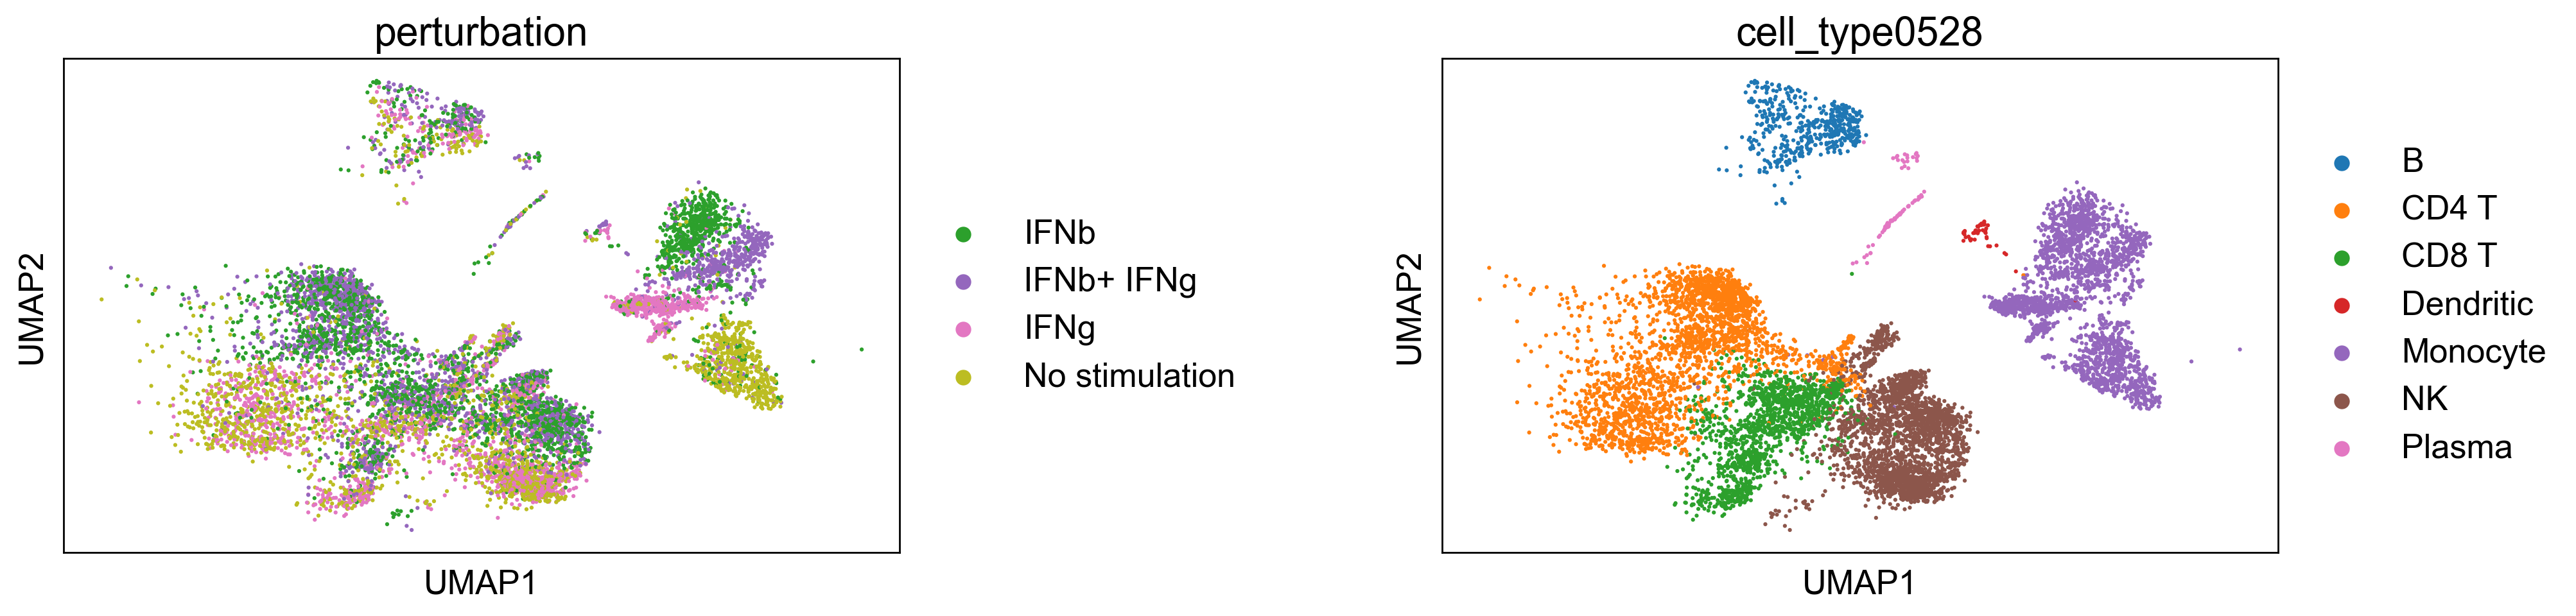

In [5]:
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams["font.size"] = 15
sc.pl.umap(adata,color=['perturbation','cell_type0528'],wspace=0.5)

# 1. CINEMA-OT analysis of mock->IFNb stimulation effects

First, we perform CINEMA-OT analysis on the subset of mock (no stimulation) to IFNb treatment. CINEMA-OT returns three outputs. First is computed confounder embedding, the second is matching matrix, the third is response matrix. Here we use TT (Treatment effect on Treated) for the matrix. Note the default setting of FastICA has low tolerance for ICA convergence. This harms CINEMA-OT little in practice.

In [8]:
adata_ = adata[adata.obs['perturbation'].isin(['No stimulation','IFNb'])]
sc.pp.pca(adata_)
cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_,obs_label='perturbation', ref_label='IFNb', expr_label='No stimulation',mode='parametric',thres=0.5,smoothness=1e-5,eps=1e-3,preweight_label='cell_type0528')

/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/guardian/Desktop/CINEMA-OT/cinemaot/cinemaot.py:146: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  TE = sc.AnnData(te2,obs=adata[adata.obs[obs_label]==ref_label,:].obs.copy(),var=adata.var.copy())


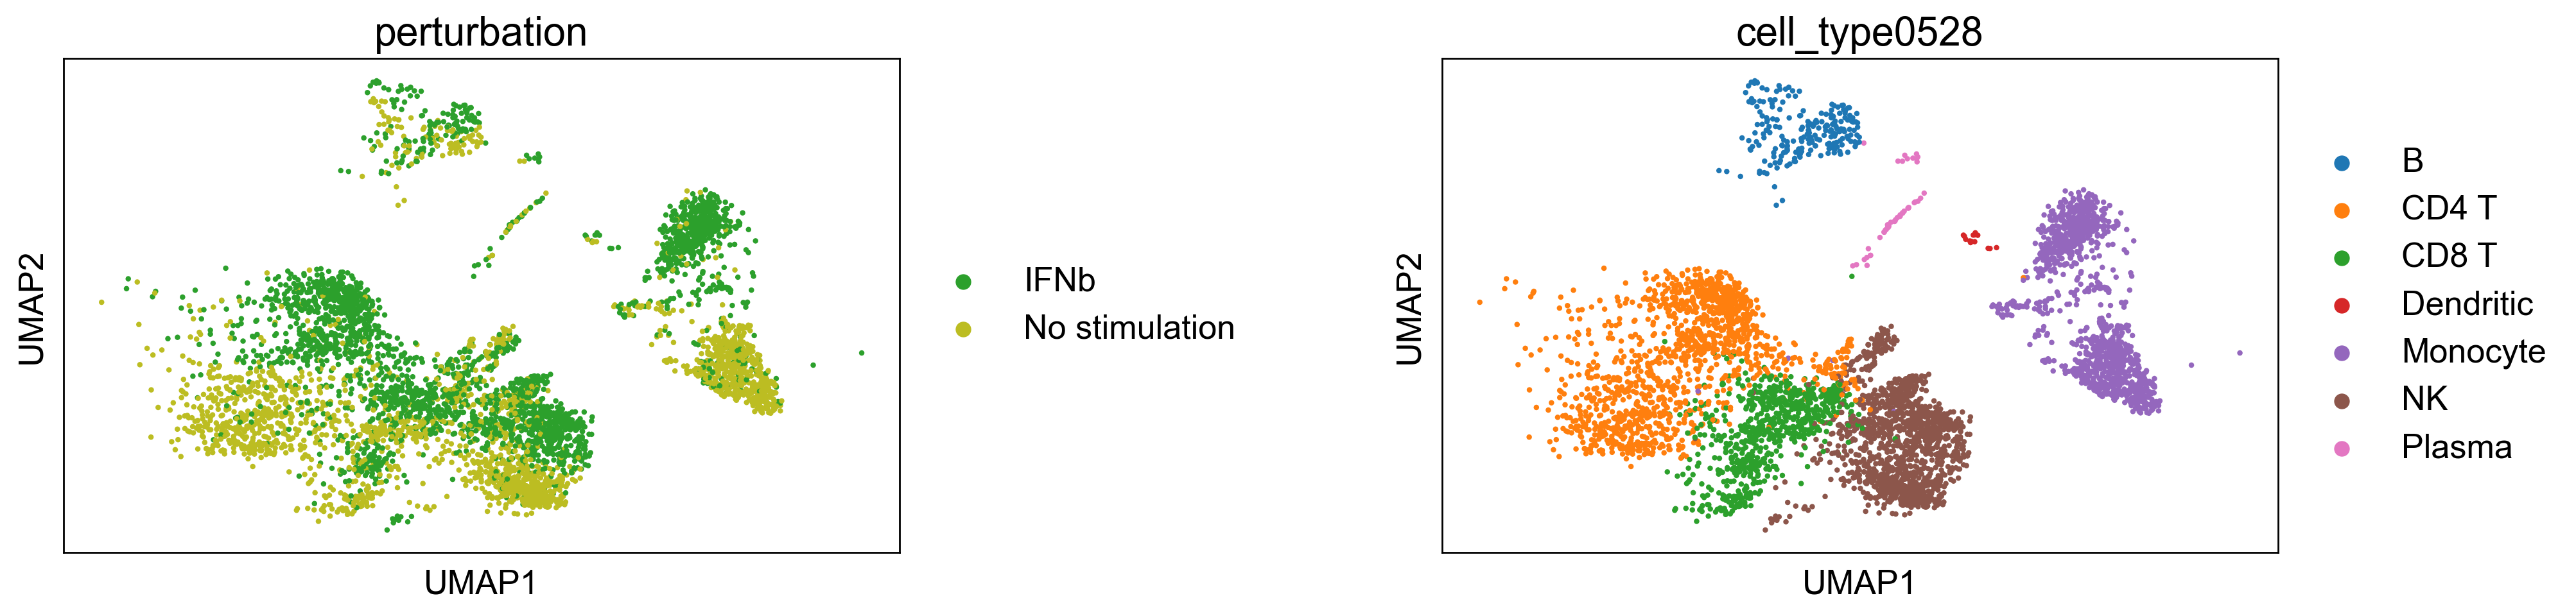

In [7]:
sc.pl.umap(adata_,color=['perturbation','cell_type0528'],wspace=0.5)

Next, we create visualization of response matrix and confounder embedding. 

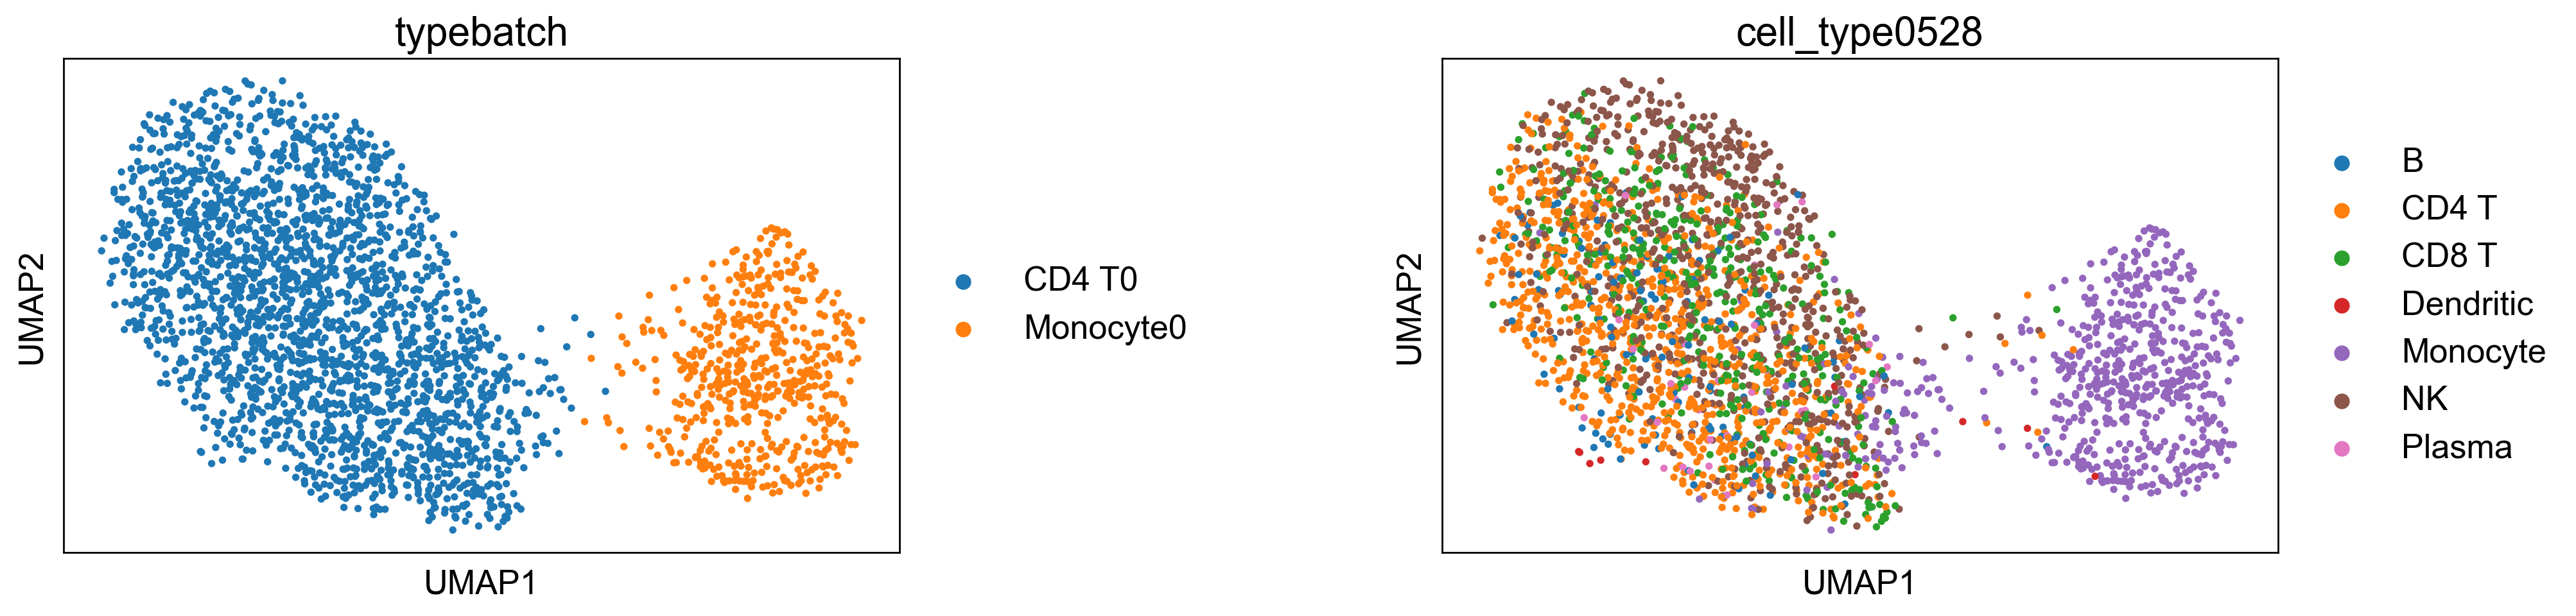

In [9]:
sc.pp.pca(de)
sc.pp.neighbors(de,use_rep='X_embedding')
sc.tl.leiden(de,resolution=0.2)
sc.tl.umap(de)
co.utils.assignleiden(de,'cell_type0528','leiden','typebatch')
sc.pl.umap(de,color=['typebatch','cell_type0528'],wspace=0.5)

Here shows the effective confounder embedding, where we use the optimal transport transformed confounders. We can see the confounders almost perfectly overlap by perturbation while separated by cell types.

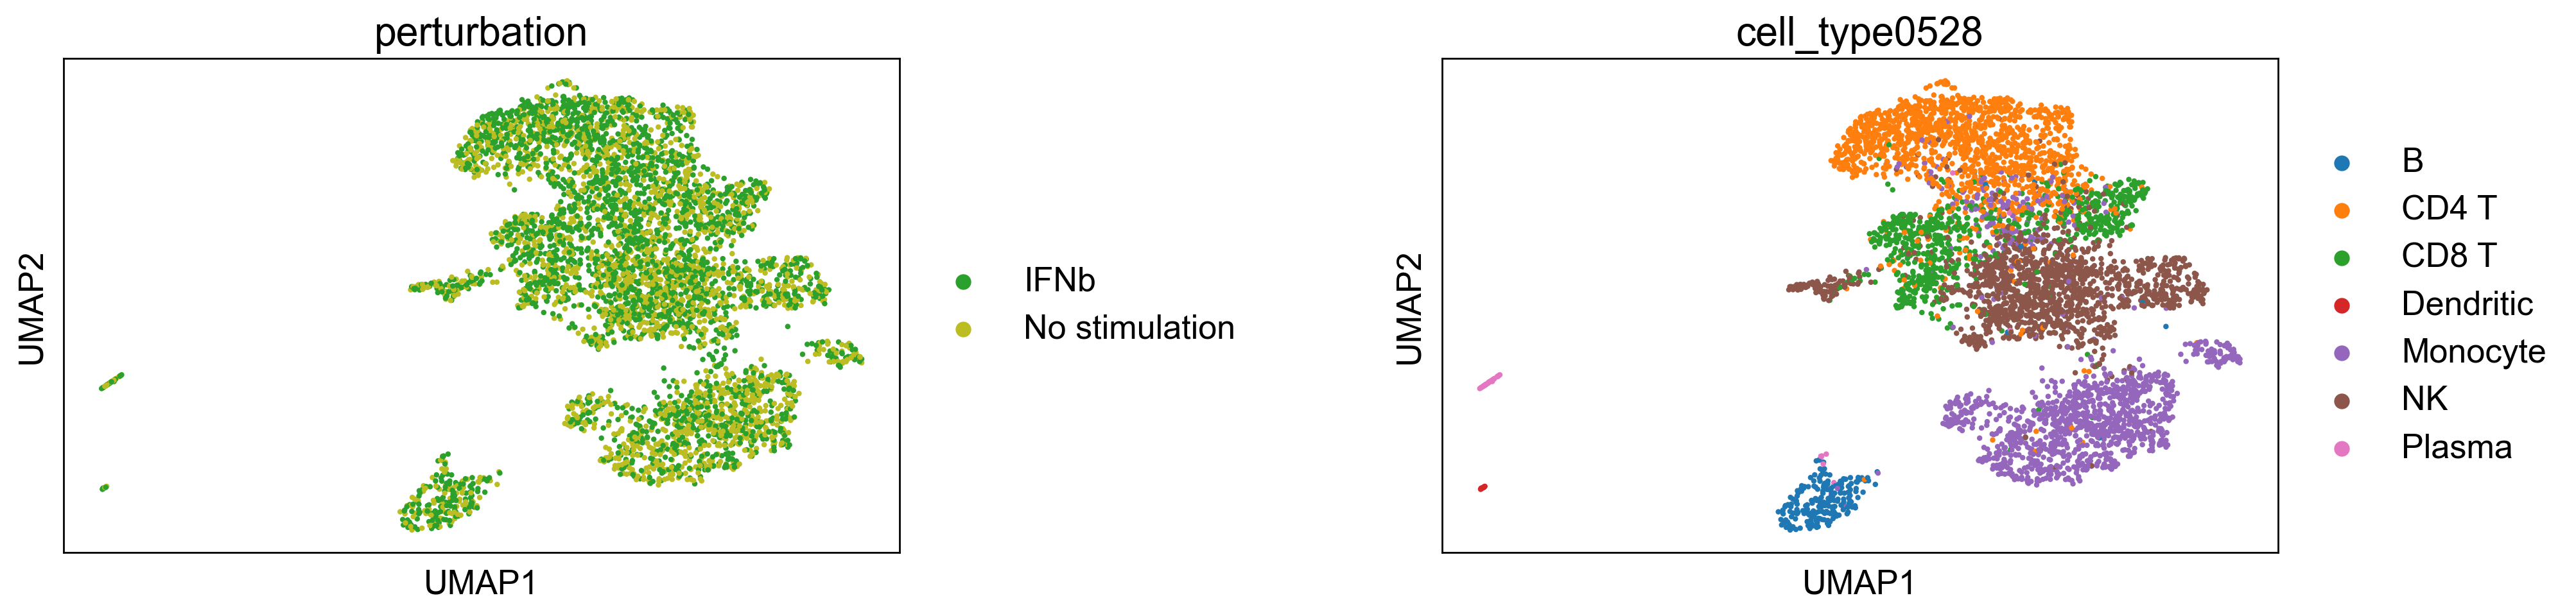

In [10]:
adata_.obsm['cf'] = cf.copy()
adata_.obsm['cf'][adata_.obs['perturbation']=='IFNb',:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs['perturbation']=='No stimulation',:])
sc.pp.neighbors(adata_,use_rep='cf')

sc.tl.umap(adata_,random_state=1)
sc.pl.umap(adata_,color=['perturbation','cell_type0528'],wspace=0.5)

Here shows the original confounder embedding, where most cell types are perfectly overlapped across treatment conditions, and different cell types are separated. The only exception is Monocyte. As CINEMA-OT uses optimal transport matching, the effective confounders (above) are eventually used in the computation.

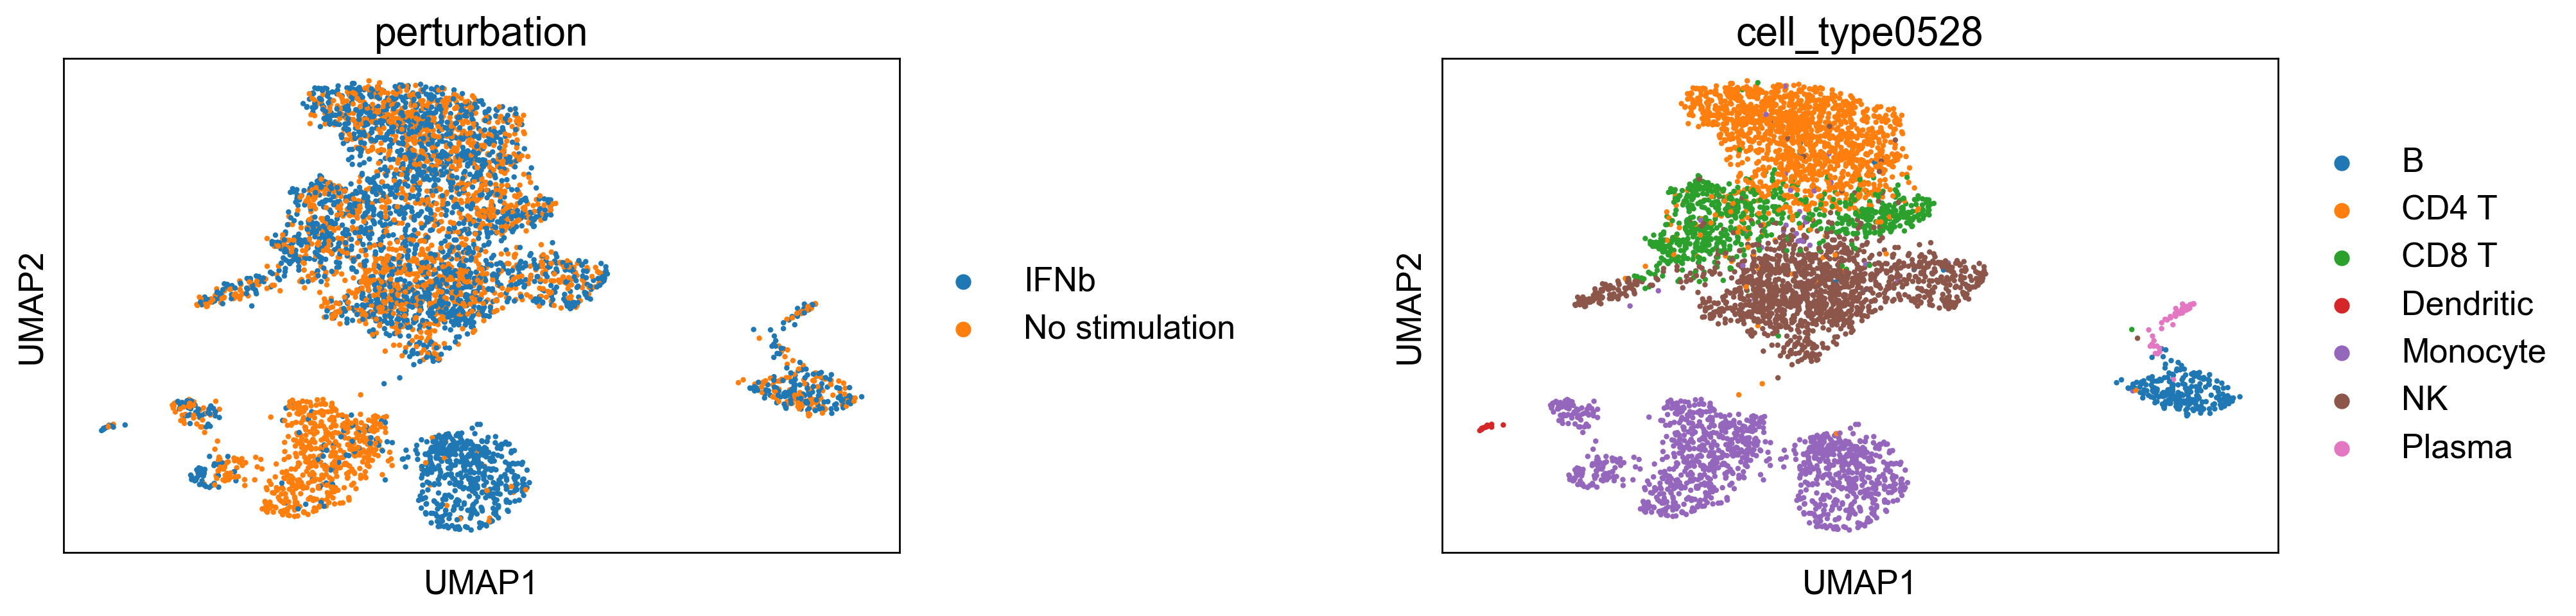

In [11]:
CF = sc.AnnData(cf,obs=adata_.obs)
sc.pp.neighbors(CF)
sc.tl.umap(CF)
sc.pl.umap(CF,color=['perturbation','cell_type0528'],wspace=0.5)

# 2. CINEMA-OT downstream analysis of mock->IFNb

Next, we perform differential expression analysis on the response matrix in scanpy. 

/opt/homebrew/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


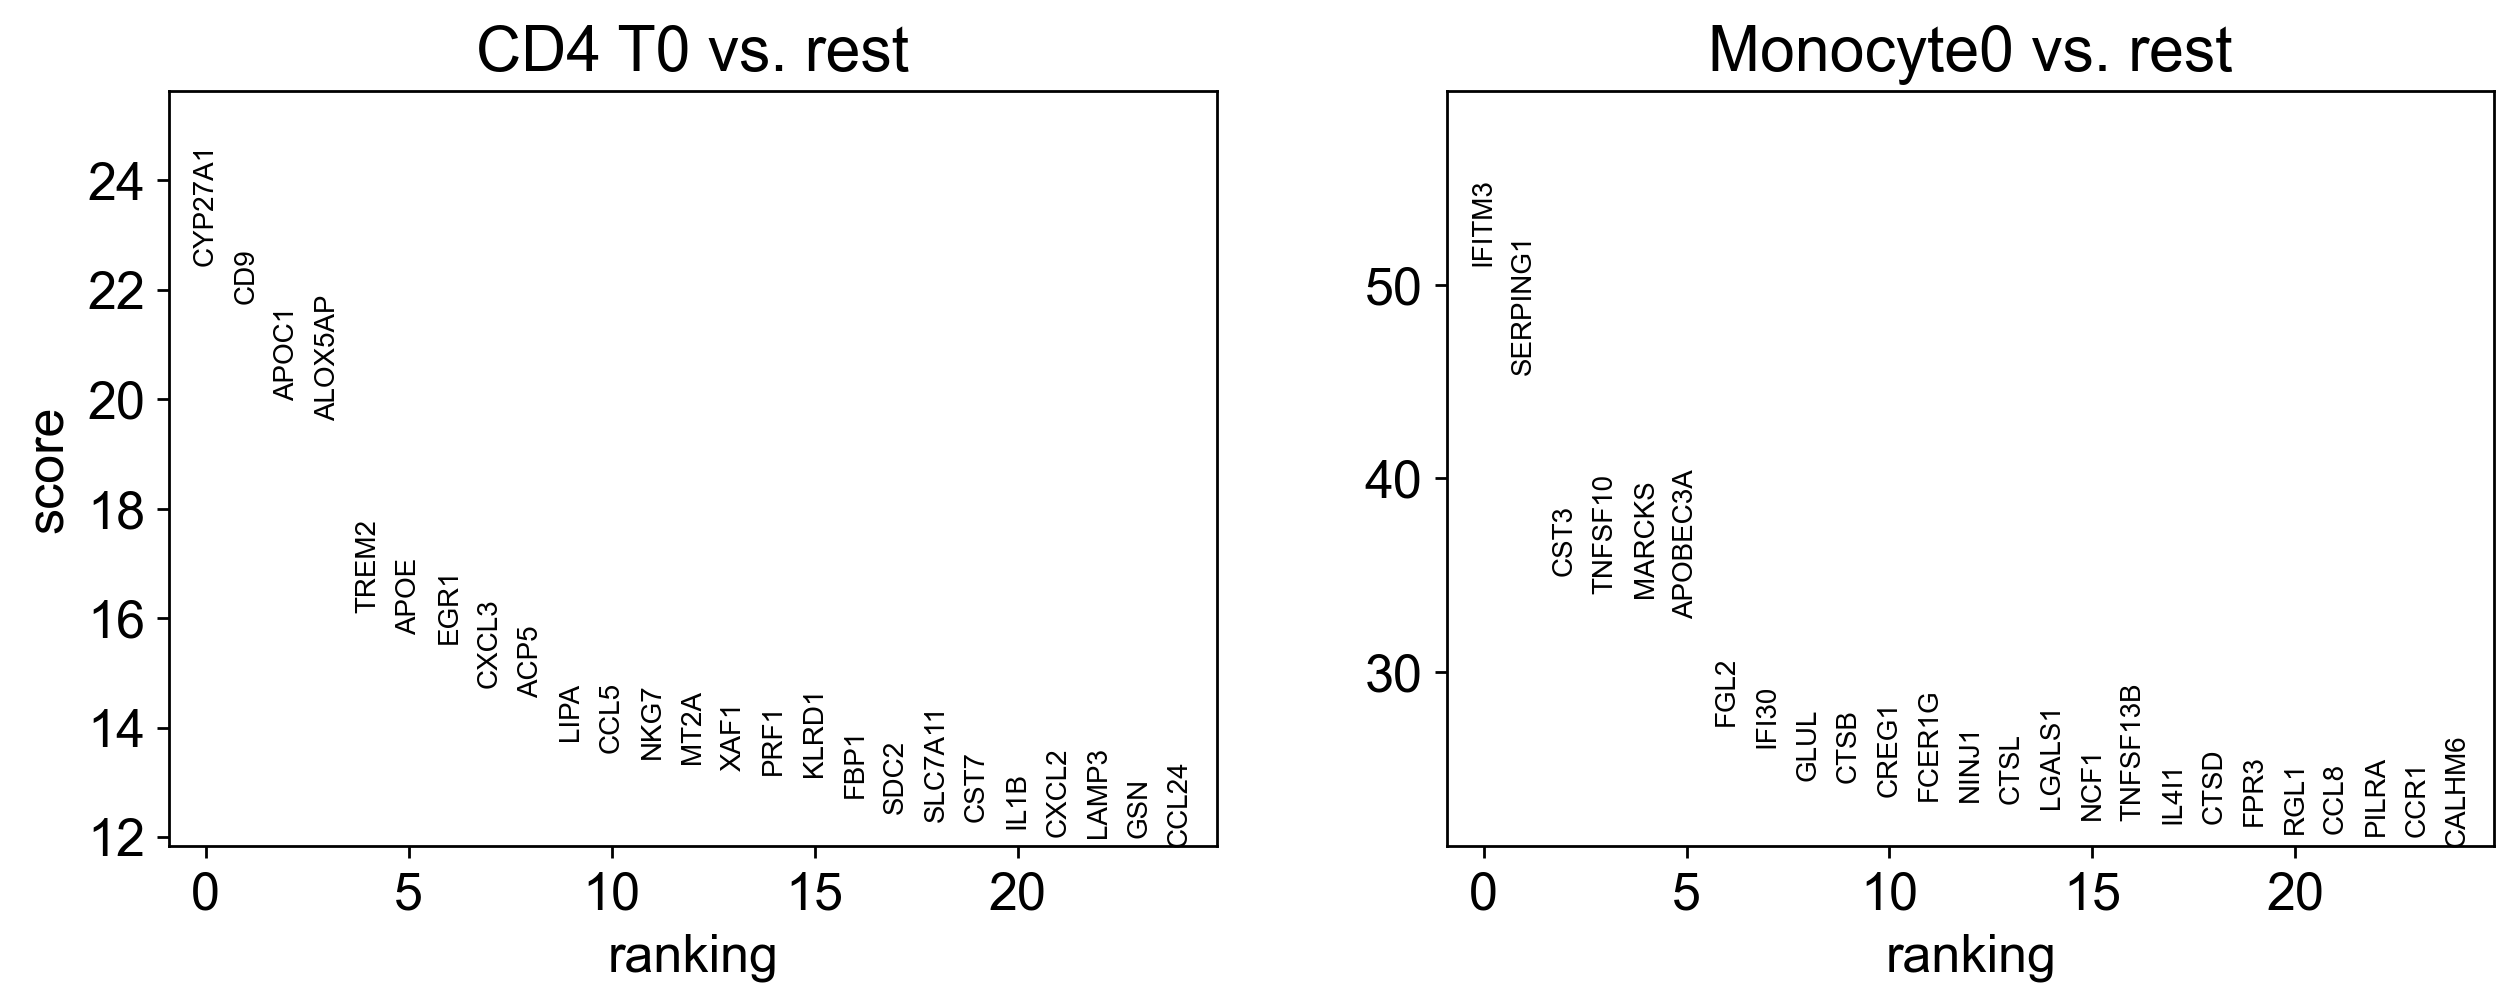

In [14]:
sc.tl.rank_genes_groups(de, 'typebatch', method='t-test')
sc.pl.rank_genes_groups(de, n_genes=25, sharey=False)

Our volcano plot approach takes advantage of the confounder embedding thus leading to more detailed characterization of confounder-specific genes. We use R to generate the volcano plot in the main figure, therefore we show the both unannotated volcano plot produced by our package and the final volcano plot produced by EnhancedVolcano package in R.

/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_57316/3812054047.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter((np.log(c_effect)),np.abs(np.log(c_effect))/(np.abs(np.log(c_effect))+np.abs(np.log(s_effect))))


Text(0, 0.5, 'Confounder effect proportion')

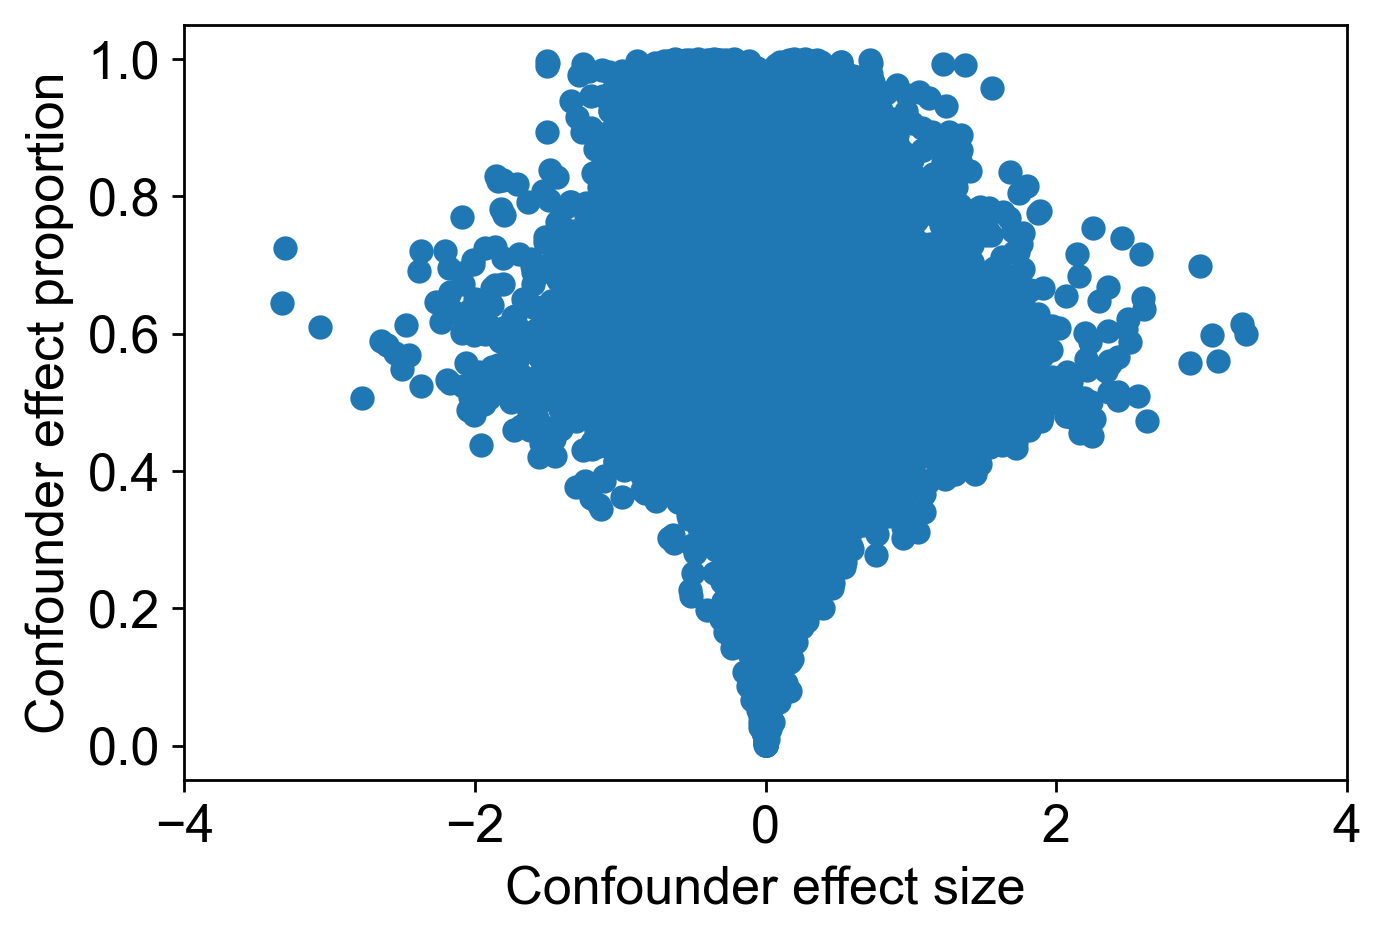

In [15]:
adata_.obsm['cf'] = cf
c_effect,s_effect=co.cinemaot.attribution_scatter(adata_,obs_label='perturbation', control_label='No stimulation', expr_label='IFNb')
plt.scatter((np.log(c_effect)),np.abs(np.log(c_effect))/(np.abs(np.log(c_effect))+np.abs(np.log(s_effect))))
plt.xlim((-4,4))
plt.xlabel('Confounder effect size')
plt.ylabel('Confounder effect proportion')
#plt.ylim((-4,4))

In [ ]:
# For R plot, we filtered over the genes so that all shown genes express in more than 50 cells.

tb = pd.DataFrame(np.vstack((np.log(c_effect),np.abs(np.log(c_effect))/(np.abs(np.log(c_effect))+np.abs(np.log(s_effect))))).T,index = adata.raw.var_names)
tb = tb[np.sum(adata_.raw.X.toarray()>0,axis=0)>50]
tb.to_csv('attribution.csv')

Here shows some characteristic genes expression highlighted by the volcano plot (Figure 5F).

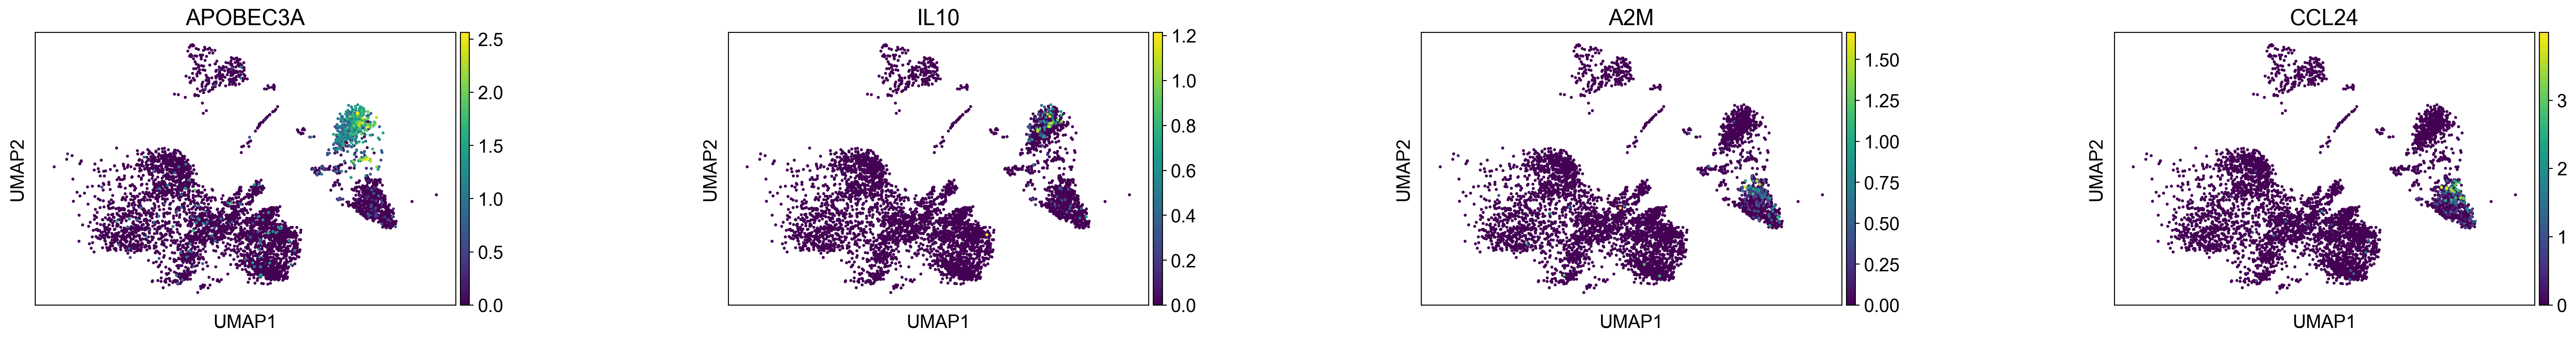

In [17]:
adata = sc.read_h5ad('Integrated_subset.h5ad')
adata_ = adata[adata.obs['perturbation'].isin(['No stimulation','IFNb'])]
sc.pl.umap(adata_,color=['APOBEC3A','IL10','A2M','CCL24'],wspace=0.5)

# 3. CINEMA-OT synergy analysis

Here we perform synergy effect analysis. In the dataset, we have three combinatorial perturbation cases: IFNb + TNFa; IFNb + IFNg; IFNb + IL-6. Here we perform CINEMA analysis on all cases via a for loop, since three is not too much. Note in the implementation below, the synergy is implemented as the difference between (A+B)+0 and (A)+(B) conditions. This is simplified as a function cinemaot.synergy in the package.

In [19]:
#Filter immune genes (optional)

import pandas as pd
TR = pd.read_csv('TR.txt',sep='\t')
HLA = pd.read_csv('HLA.txt',sep='\t')
IG = pd.read_csv('IG.txt',sep='\t')

filterlist = list(set(TR['Approved symbol'].values.tolist()) | set(HLA['Approved symbol'].values.tolist()) | set(IG['Approved symbol'].values.tolist()))
perturbationlist = list(set(adata.obs['perturbation'].values.tolist()))
adata_ = adata[:,~adata.var_names.isin(filterlist)]
response = adata_[adata_.obs['perturbation'].isin(['No stimulation']),:]
for i in perturbationlist:
    if i != 'No stimulation':
        adata_ = adata[:,~adata.var_names.isin(filterlist)]
        adata_ = adata_[adata_.obs['perturbation'].isin(['No stimulation',i]),:]
        sc.pp.pca(adata_)
        cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_,obs_label='perturbation', ref_label='No stimulation', expr_label=i,mode='parametric',thres=0.5,smoothness=1e-4,eps=1e-2,preweight_label='cell_type0528')
        subset_mock = adata_[adata_.obs['perturbation'].isin(['No stimulation']),:]
        de_c = sc.AnnData(subset_mock.X.toarray()-de.X)
        de_c.obs['cell_type0528'] = subset_mock.obs['cell_type0528'].values
        de_c.obs['perturbation'] = i
        de_c.var_names = subset_mock.var_names
        response = sc.concat([response,de_c])

sc.pp.pca(response)
sc.pp.neighbors(response)
sc.tl.umap(response)
synergylist = ['IFNb','IFNb+ IFNg','IFNg','No stimulation']
combolist = ['IFNb+ IFNg']
synergy = response[response.obs['perturbation'].isin(combolist),:].copy()
combo = response[response.obs['perturbation'].isin(combolist),:].copy()

combo.X[combo.obs['perturbation']=='IFNb+ IFNg',:] = response.X[response.obs['perturbation']=='IFNb+ IFNg',:]-response.X[response.obs['perturbation']=='IFNb',:] - response.X[response.obs['perturbation']=='IFNg',:] + response.X[response.obs['perturbation']=='No stimulation',:]


combo

/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/guardian/Desktop/CINEMA-OT/cinemaot/cinemaot.py:146: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  TE = sc.AnnData(te2,obs=adata[adata.obs[obs_label]==ref_label,:].obs.copy(),var=adata.var.copy())
/opt/homebrew/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decompos

AnnData object with n_obs × n_vars = 2268 × 596
    obs: 'perturbation', 'cell_type0528'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Text(0.5, 1.0, 'Gene synergy score distribution')

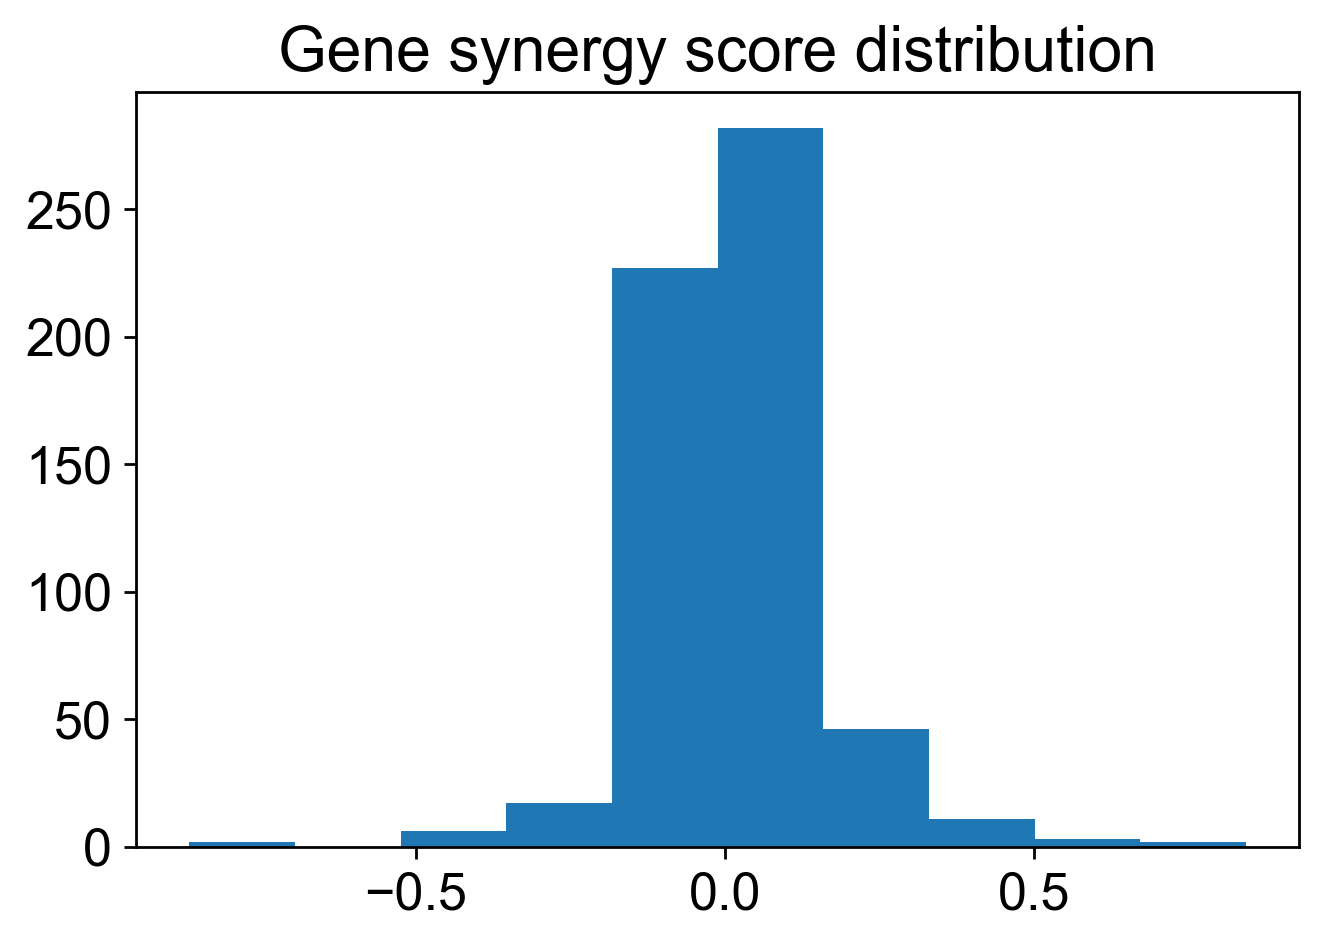

In [20]:
plt.hist(np.mean(combo.X,axis=0))
plt.title('Gene synergy score distribution')

Based on gene synergy, we filter insignificant synergy genes and perform cell synergy analysis. In the tutorial, we only use one combination instead of all possible combinations used in paper, which leads to slightly different visualizations.

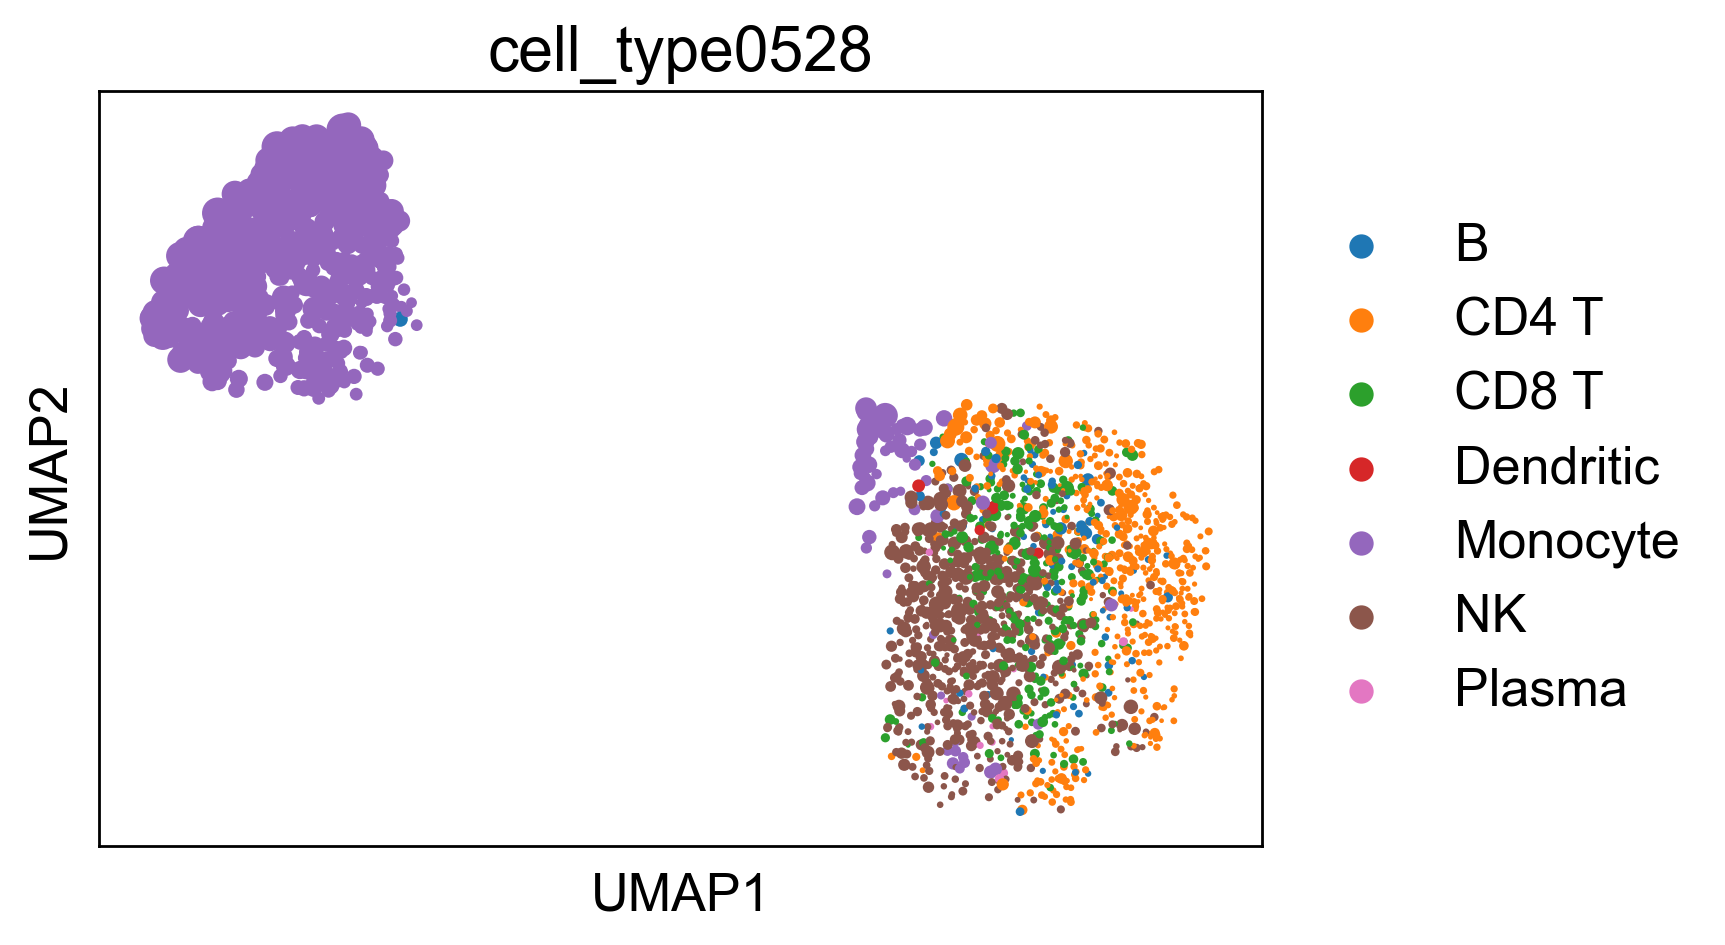

In [21]:
sc.pp.pca(combo)
sc.pp.neighbors(combo)
sc.tl.umap(combo)
synergyscore = np.linalg.norm(combo.X[:,np.abs(np.mean(combo.X,axis=0))>0.15],axis=1)
sc.pl.umap(combo,color=['cell_type0528'],wspace=0.5,size=0.3*synergyscore**2)

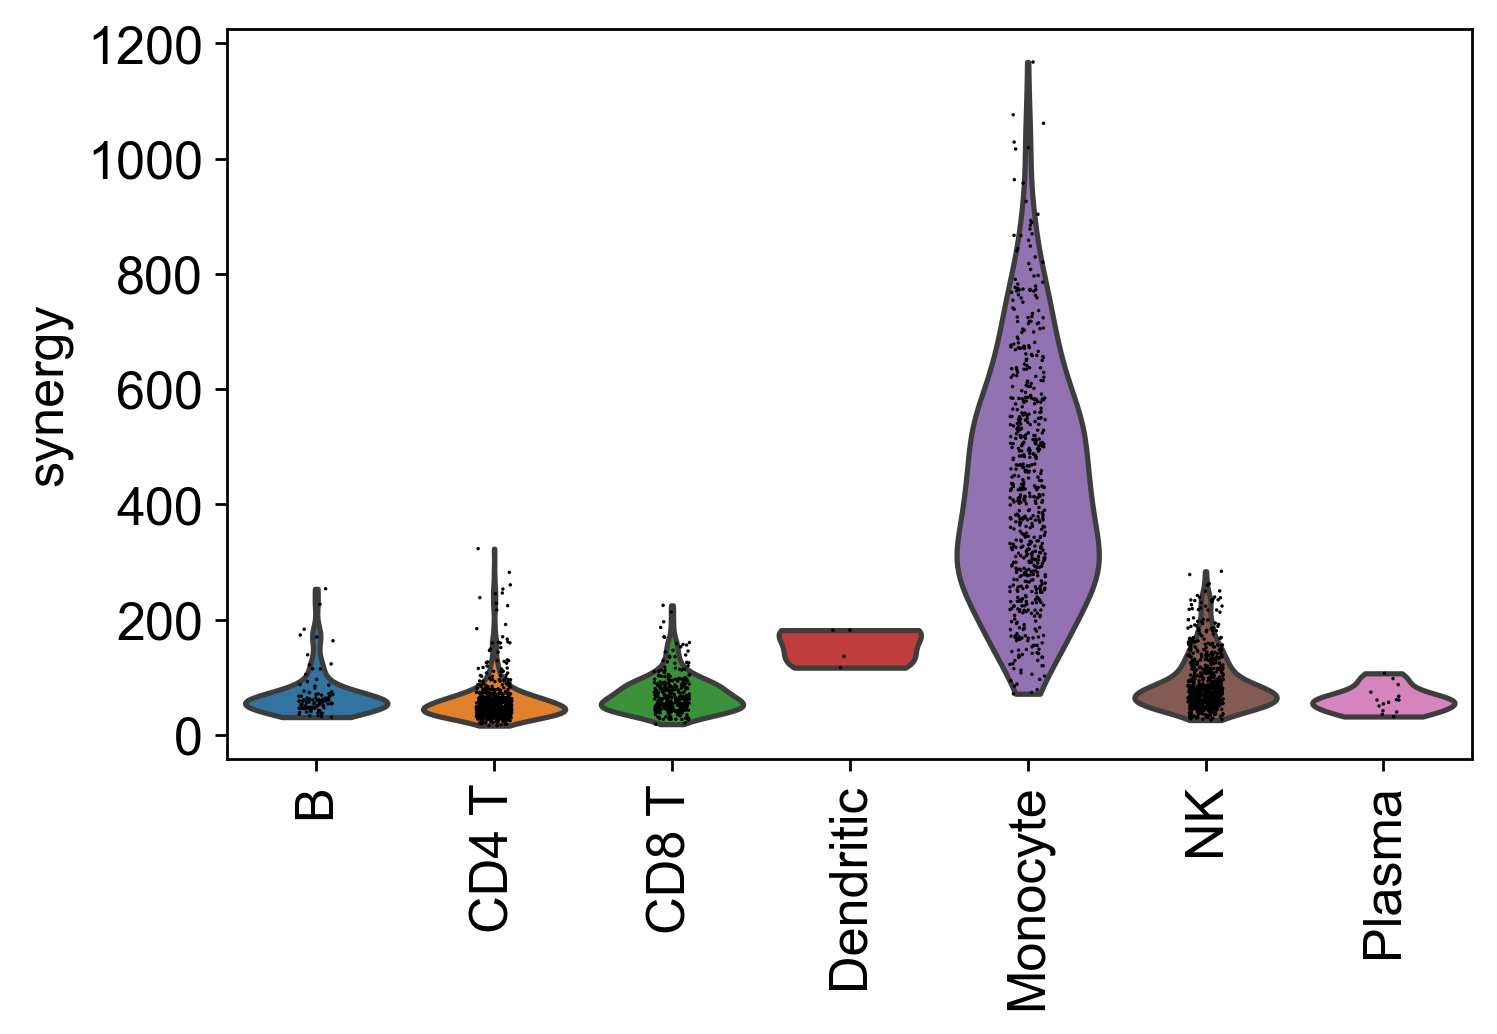

In [22]:
combo.obs['synergy'] = synergyscore ** 2
sc.pl.violin(combo,keys=['synergy'],groupby='cell_type0528',rotation=90)

We can identify different modes of synergistic response through visualization of synergy matrix:

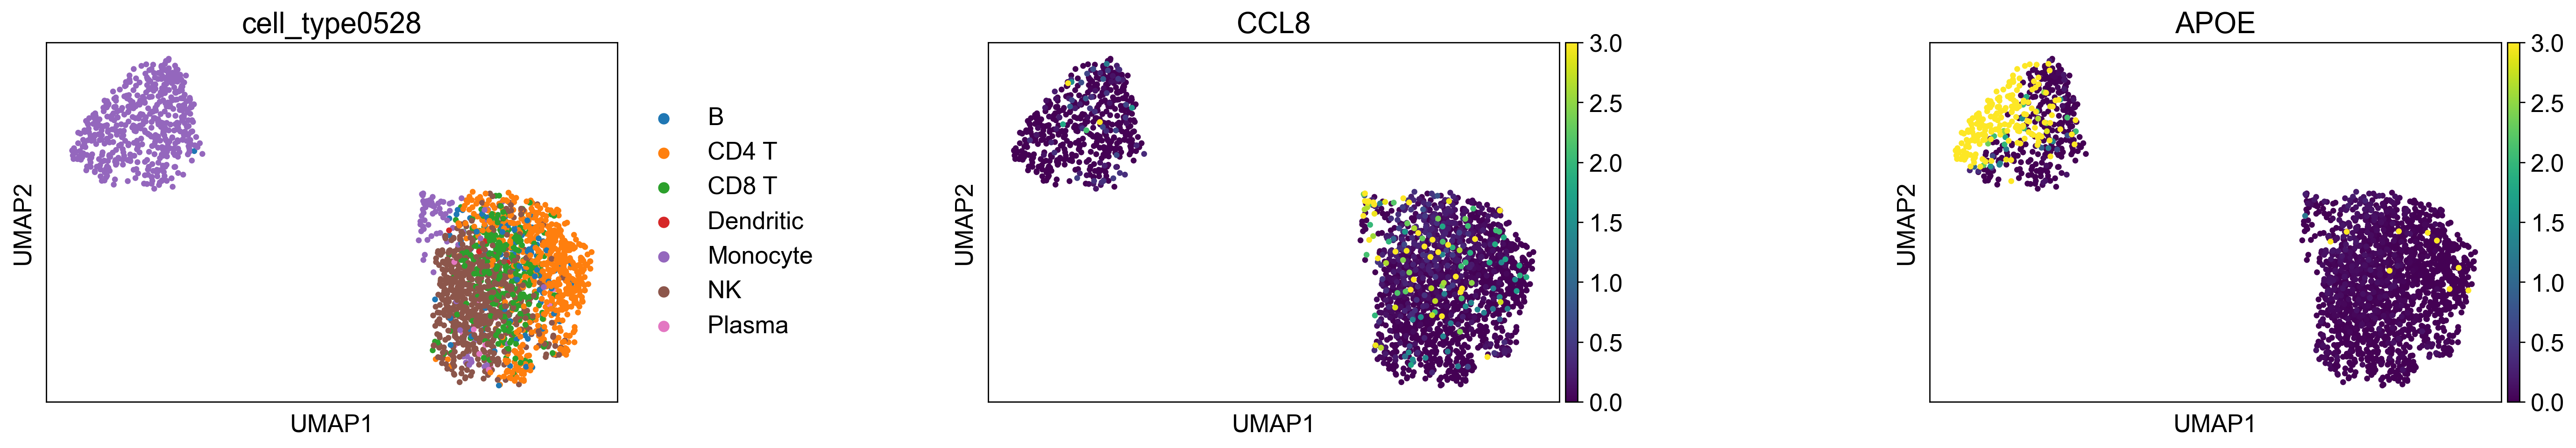

In [23]:
sc.pl.umap(combo,color=['cell_type0528','CCL8','APOE'],wspace=0.5,vmin=0,vmax=3)